In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from common_variables import *
from time_series import *

In [9]:
#将所有的数据训练两百次
epochs = 20
np.random.seed(seed)
tf.random.set_random_seed(seed)

In [10]:
# dayfirst:DD/MM格式的日期类型
df = pd.read_csv(train_time_series_path, dayfirst=True, 
    index_col=['Date_Time'], parse_dates=['Date_Time'])
df

,Unnamed: 0,HLAvg,MA,Returns
Date_Time,,,,
2001-01-01,64,114.460,114.508929,-0.000062
2001-01-01,66,114.495,114.505714,-0.000028
2001-01-01,68,114.435,114.494643,-0.000097
2001-01-01,70,114.430,114.482500,-0.000106
2001-01-01,72,114.395,114.478571,-0.000034
...,...,...,...,...
2001-01-01,1027830,124.075,124.060000,0.000003
2001-01-01,1027832,124.040,124.058929,-0.000009
2001-01-01,1027834,124.045,124.057500,-0.000012


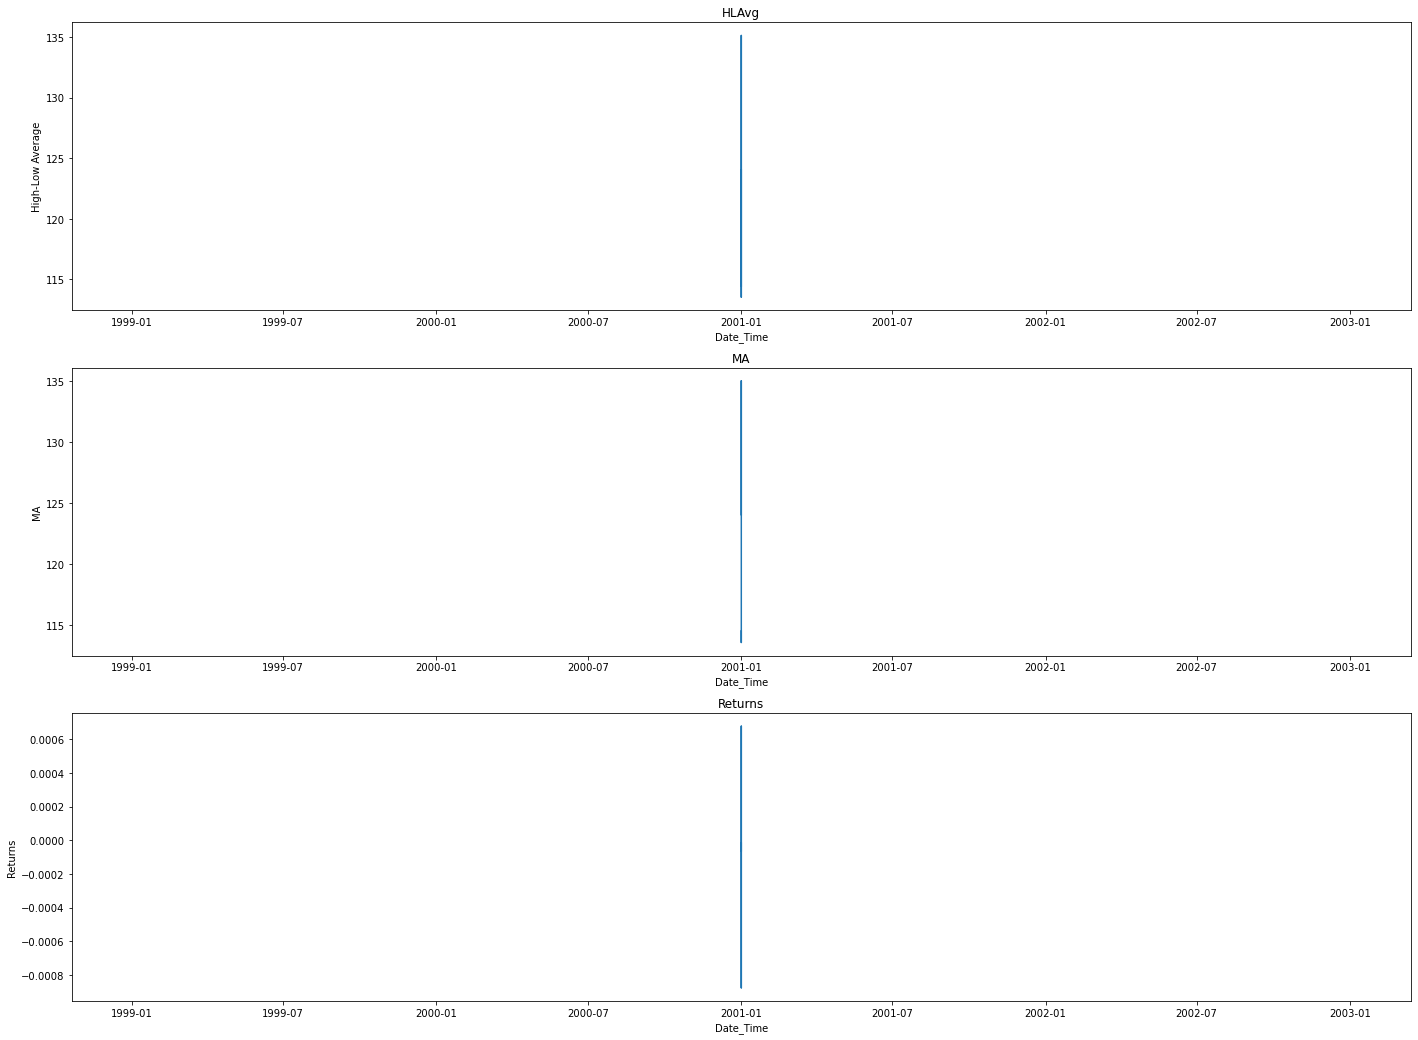

In [11]:
# 创建一个图像，宽高为24,18
fig = plt.figure(figsize=(24, 18))
# subplots 将fig划分为三个子图
ax1, ax2, ax3 = fig.subplots(3)
ax1.set_title('HLAvg')
ax1.set(xlabel='Date_Time', ylabel='High-Low Average')
# 作图
ax1.plot(df['HLAvg'])
ax2.set_title('MA')
ax2.set(xlabel='Date_Time', ylabel='MA')
ax2.plot(df['MA'])
ax3.set_title('Returns')
ax3.set(xlabel='Date_Time', ylabel='Returns')
ax3.plot(df['Returns'])

In [12]:
# 数据归一化处理，将所有数据收敛到 0-1区间
scaler = MinMaxScaler()
train_values = scaler.fit_transform(df[['Returns']].values)

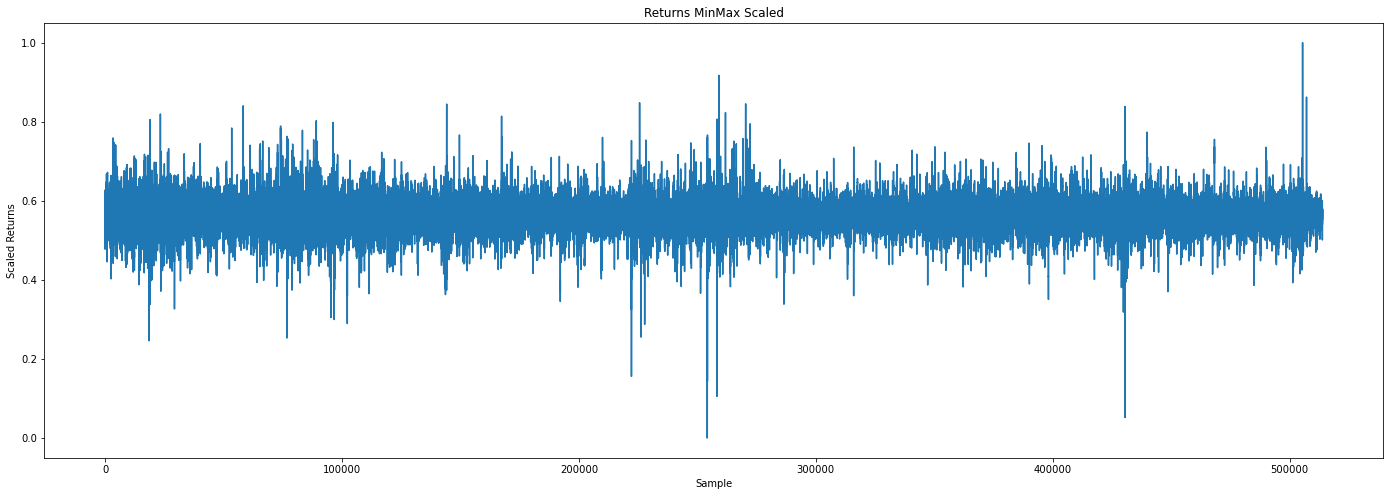

In [13]:
fig = plt.figure(figsize=(24, 8))
ax1 = fig.subplots(1)
ax1.set_title('Returns MinMax Scaled')
ax1.set(xlabel='Sample', ylabel='Scaled Returns')
ax1.plot(train_values)

In [14]:
X, y = get_train(train_values, window_size)

X (513632, 256, 1), y (513632, 1)


In [15]:
df_val = pd.read_csv(validate_time_series_path, dayfirst = True, usecols=['Date_Time','Returns'],
    index_col=['Date_Time'], parse_dates=['Date_Time'])
# transform:归一化处理，将数据收敛到0-1区间
df_val['Scaled'] = scaler.transform(df_val[['Returns']].values)
X_val, y_val = get_val(df_val['Scaled'].values, window_size)

X (5184, 256, 1), y (5184,)


In [16]:
#序贯模型（Sequential):单输入单输出，一条路通到底，层与层之间只有相邻关系，没有跨层连接。
# 这种模型编译速度快，操作也比较简单
model = Sequential()
# units = 76,每一层神经元的数量
# input_shape():第一个代表每个输入的样本序列长度(256)，第二个元素代表 每个序列里面的1个元素具有多少个输入数据。
# return_sequences 是否返回全部输出的序列。False否，True返回全部输出，框架默认
# 具体的解释请参考：https://blog.csdn.net/sinat_35576477/article/details/91340437
model.add(LSTM(76, input_shape=(X.shape[1], 1), return_sequences = False))
# 使多少比重的神经元输出（unit的输出）激活失效，默认为0，模仿原文为0
model.add(Dropout(0.2))
# Dense 全连接神经网络层
model.add(Dense(1))
# 使用adam梯度下降算法
optimizer = tf.keras.optimizers.Adam()
# 损失函数mse  可以反映一个数据集的离散程度。
model.compile(loss="mse", optimizer=optimizer)
# 输出模型各层的参数状况
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 76)                23712     
_________________________________________________________________
dropout (Dropout)            (None, 76)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 77        
Total params: 23,789
Trainable params: 23,789
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
# X输入数据 y标签 validation_data:验证集数据 epochs:训练次数
# shuffle:表示是否在训练过程中随机打乱输入样本的顺序。
# verbose：日志显示，0为不在标准输出流输出日志信息，1为输出进度条记录，2为每个epoch输出一行记录
# fit函数返回一个History的对象，
# 其History.history属性记录了损失函数和其他指标的数值随epoch变化的情况，
# 如果有验证集的话，也包含了验证集的这些指标变化情况
history = model.fit(X, y, validation_data=(X_val, y_val), epochs = epochs, batch_size = batch_size, shuffle=False, verbose = 2)

Train on 513632 samples, validate on 5184 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
513632/513632 - 2504s - loss: 5.0279e-04 - val_loss: 1.3750e-04
Epoch 2/20
513632/513632 - 2343s - loss: 1.2010e-04 - val_loss: 1.2109e-04
Epoch 3/20
513632/513632 - 2209s - loss: 1.1066e-04 - val_loss: 1.1433e-04
Epoch 4/20
513632/513632 - 2152s - loss: 1.0197e-04 - val_loss: 1.1975e-04
Epoch 5/20
513632/513632 - 2447s - loss: 9.7446e-05 - val_loss: 1.0831e-04
Epoch 6/20
513632/513632 - 2486s - loss: 9.4036e-05 - val_loss: 1.0713e-04
Epoch 7/20
513632/513632 - 2478s - loss: 9.0745e-05 - val_loss: 1.0673e-04
Epoch 8/20
513632/513632 - 2584s - loss: 8.5977e-05 - val_loss: 9.3149e-05
Epoch 9/20
513632/513632 - 2931s - loss: 8.2042e-05 - val_loss: 8.7042e-05
Epoch 10/20
513632/513632 - 2921s - loss: 7.8764e-05 - val_loss: 8.7178e-05
Epoch 11/20
513632/513632 - 2124s - loss: 7.8573e-05 - val_loss: 8.9860e-05
Epoch 12/20
513632/513632 - 2

In [18]:
# 保存模型
save_model(model, model_path)
#  保存训练模型
joblib.dump(scaler, scaler_path) 


['scalers/USDJPY.M1-32-256-14.bin']

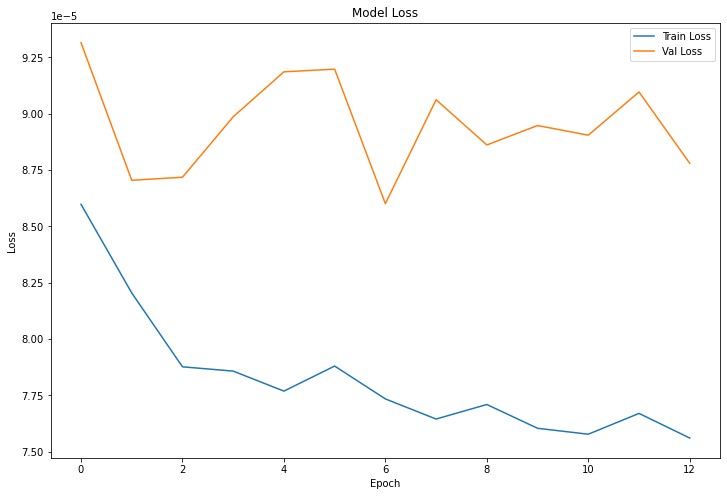

In [19]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.subplots(1)
ax1.set_title('Model Loss')
ax1.set(xlabel='Epoch', ylabel='Loss')
ax1.plot(history.history['loss'][7:], label='Train Loss')
ax1.plot(history.history['val_loss'][7:], label='Val Loss')
ax1.legend()